# Fifa 18 Value Prediction
## Data Modeling

### Table of Contents

1. [Data Preparation](#preparation)
    1. [Load the data](#load)
    2. [Prepare the data](#prepare)
    3. [Feature selection](#feature_selection)
    4. [Train and test split](#split)
2. [Data Modeling](#modeling)
    1. [Linear Regression Model](#linear_regression)
    2. [Polynomial Regression Model](#polynomial_regression)
    3. [Lasso Regression](#lasso_regression)
3. [Model Evaluation](#evaluation)
    1. [RMSE](#rmse)
    2. [Cross Validation](#cross_validation)
    3. [Learning Curves](#learning_curves)
4. [Export the results](#export)

In [20]:
# Imports
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from IPython.display import display, Markdown as md
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures


# Config
%matplotlib notebook
pd.options.display.max_columns = None

## Data Preparation <a id="preparation"></a>
### Load the data <a id="load"></a>
Loads *.csv* file into *pandas DataFrame*

In [21]:
df = pd.read_csv("data/processed/CompleteDataset_cleaned.csv", sep=";")

### Prepare the data <a id="prepare"></a>
To simplify the model, let's exclude the goalkeepers (*GK*), so we don't have to deal with *null* values.

In [22]:
df_model = df.drop("Name", axis="columns")

exclude_GK = df_model["Preferred Position_GK"] == 0
df_model = df_model[exclude_GK]

In [23]:
# Define 'target' and 'features'
target = "Value"
features = df_model.columns.values
features = features[features != target]

X = df_model.loc[:, features]
y = df_model.loc[:, [target]]

### Feature selection<a id="feature_selection"></a>
Let's apply a *feature selection* method in order to reduce the number of attributes in the dataset. Fewer attributes is desirable because it reduces the complexity of the model, and a simpler model is simpler to understand and explain.

In [24]:
feature_selector = SelectKBest(chi2, k=40)
X = feature_selector.fit_transform(X, y)
features_selected = feature_selector.get_support()

display(md("*X* shape: {0}".format(X.shape)))

features = features[features_selected] # Update 'features'

*X* shape: (15952, 40)

### Train and test split <a id="split"></a>
Splits the dataset into a *train set* (80%) and *test set* (20%)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

display(md("*X_train* shape: {0} - *X_test* shape: {1}".format(X_train.shape, X_test.shape)))
display(md("*y_train* shape: {0} - *y_test* shape: {1}".format(y_train.shape, y_test.shape)))

*X_train* shape: (12761, 40) - *X_test* shape: (3191, 40)

*y_train* shape: (12761, 1) - *y_test* shape: (3191, 1)

## Data Modeling <a id="modeling"></a>
### Linear Regression Model <a id="linear_regression"></a>
Creates and fits the model

In [26]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Let's visualize the highest *Linear Regression coefficients*

<IPython.core.display.Javascript object>


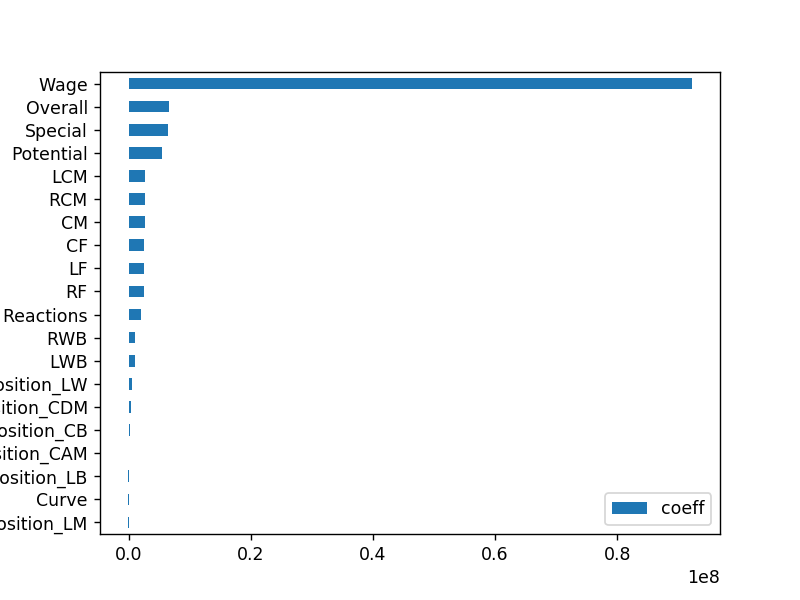

In [27]:
# Create new DataFrame with the coefficients per each feature
coeff_df = pd.DataFrame(data=lin_reg.coef_[0], index=features, columns=["coeff"])
coeff_df.sort_values(by="coeff", ascending=False, inplace=True) # Sort 'coeff_df' in descending order

coeff_df.iloc[0:20].sort_values(by="coeff").plot.barh()

Saves the prediction in *predictions*

In [28]:
predictions = lin_reg.predict(X_test)

### Polynomial Regression Model <a id="polynomial_regression"></a>
A simple way to use a linear model to fit nonlinear data is to add powers of each feature as new features, and then train a linear model on this extended set of features.

In [29]:
d = 2
poly_features = PolynomialFeatures(degree=d, include_bias=False)

# Add the square of each feature and the combinations of features up to 2 degree
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

The number of features created by *PolynomialFeatures* can be calculated with the following equation:

\begin{align}
\frac{(n + d)!}{d!n!}\
\end{align}

In [30]:
n = X.shape[1]
poly_features_count = int(math.factorial(n + d) / (math.factorial(d) * math.factorial(n))) - 1

display(md("*X_train_poly* should now have {0} features".format(poly_features_count)))

display(md("*X* shape: {0}".format(X.shape)))
display(md("*X_train_poly* shape: {0}".format(X_train_poly.shape)))
display(md("*X_test_poly* shape: {0}".format(X_test_poly.shape)))

*X_train_poly* should now have 860 features

*X* shape: (15952, 40)

*X_train_poly* shape: (12761, 860)

*X_test_poly* shape: (3191, 860)

In [31]:
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
predictions_poly = poly_reg.predict(X_test_poly)

### Lasso Regression<a id="lasso_regression"></a>
Is a regularized version of *Linear Regression*. It adds a regularization term to the cost function. This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible.

In [32]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=1)
lasso_reg.fit(X_train_poly, y_train)
predictions_lasso = lasso_reg.predict(X_test_poly)

c:\users\matias\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## Model Evaluation <a id="evaluation"></a>
### RMSE <a id="rmse"></a>

In [33]:
lin_mse = mean_squared_error(predictions, y_test)
poly_mse = mean_squared_error(predictions_poly, y_test)
lasso_mse = mean_squared_error(predictions_lasso, y_test)
lin_rmse = np.sqrt(lin_mse)
poly_rmse = np.sqrt(poly_mse)
lasso_rmse = np.sqrt(lasso_mse)

display(md("**Linear Regression - Root Mean Squared Error: €{0:,}**".format(int(lin_rmse))))
display(md("**Polynomial Regression - Root Mean Squared Error: €{0:,}**".format(int(poly_rmse))))
display(md("**Lasso Regression - Root Mean Squared Error: €{0:,}**".format(int(lasso_rmse))))

**Linear Regression - Root Mean Squared Error: €2,563,231**

**Polynomial Regression - Root Mean Squared Error: €1,359,565**

**Lasso Regression - Root Mean Squared Error: €1,358,909**

### Cross Validation <a id="cross_validation"></a>

In [34]:
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)

poly_scores = cross_val_score(poly_reg, X_train_poly, y_train, scoring="neg_mean_squared_error", cv=5)
poly_rmse_scores = np.sqrt(-poly_scores)

lasso_scores = cross_val_score(lasso_reg, X_train_poly, y_train, scoring="neg_mean_squared_error", cv=5)
lasso_rmse_scores = np.sqrt(-lasso_scores)

display(md("**Linear Regression Model**"))
display(md("Scores: {0}".format(lin_rmse_scores)))
display(md("Mean: {0:,.2f}".format(lin_rmse_scores.mean())))
display(md("Standard deviation: {0:,.2f}".format(lin_rmse_scores.std())))

display(md("**Polynomial Regression Model**"))
display(md("Scores: {0}".format(poly_rmse_scores)))
display(md("Mean: {0:,.2f}".format(poly_rmse_scores.mean())))
display(md("Standard deviation: {0:,.2f}".format(poly_rmse_scores.std())))

display(md("**Lasso Regression Model**"))
display(md("Scores: {0}".format(lasso_rmse_scores)))
display(md("Mean: {0:,.2f}".format(lasso_rmse_scores.mean())))
display(md("Standard deviation: {0:,.2f}".format(lasso_rmse_scores.std())))

c:\users\matias\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matias\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matias\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matias\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want t

**Linear Regression Model**

Scores: [2633556.28272506 2672835.51951707 2733699.22954182 2568839.11605388
 2528812.42539231]

Mean: 2,627,548.51

Standard deviation: 72,870.56

**Polynomial Regression Model**

Scores: [1465359.78057266 1332521.65951097 1390189.29504785 1443802.14779562
 1323463.41522829]

Mean: 1,391,067.26

Standard deviation: 57,094.63

**Lasso Regression Model**

Scores: [1478754.7004349  1333103.00595044 1345342.06365019 1443688.10558567
 1283549.66359192]

Mean: 1,376,887.51

Standard deviation: 72,750.80

### Learning Curves <a id="learning_curves"></a>
These are plots of the model's performance on the training set and the validation set as a function of the training set size. These plots help us to analyze if the models are *underfitting* or *overfitting* the data.

In [35]:
def plot_learning_curves(model, X, y, step=500):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    x_values = range(1, len(X_train), step)
    for m in x_values:
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(x_values, np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(x_values, np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)
    plt.yscale("log")
    


The **Linear Regression Model** is underfitting the data. The curves reached a plateau, and adding more training examples don't help. We have to use a more complex model (*Polynomial Regression Model*) or come up with better features.

<IPython.core.display.Javascript object>


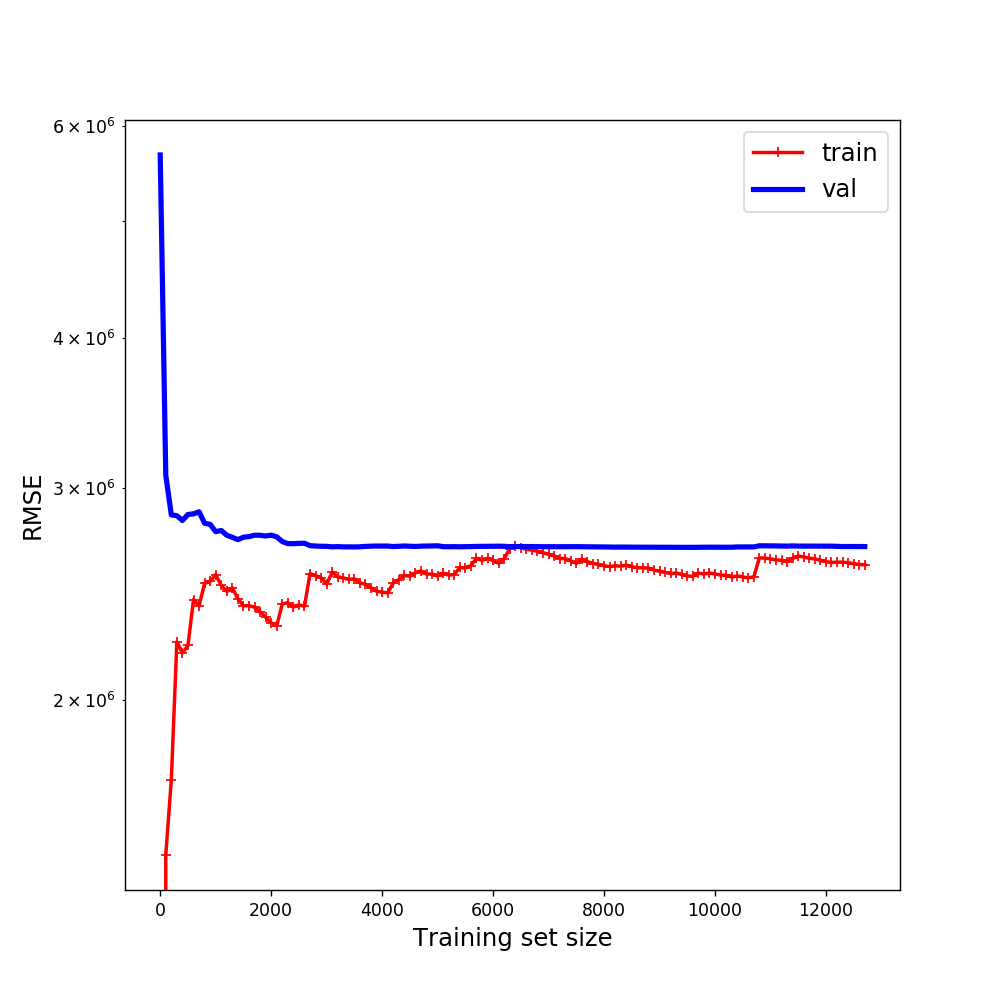

In [36]:
# Plots the learning curves for the Linear Regression Model
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y, step=100)
plt.show()

The **Polynomial Regression Model** overfits (the gap between the curves is huge!) until ≈9000 training examples. Then, it seems that the model fits great.

<IPython.core.display.Javascript object>


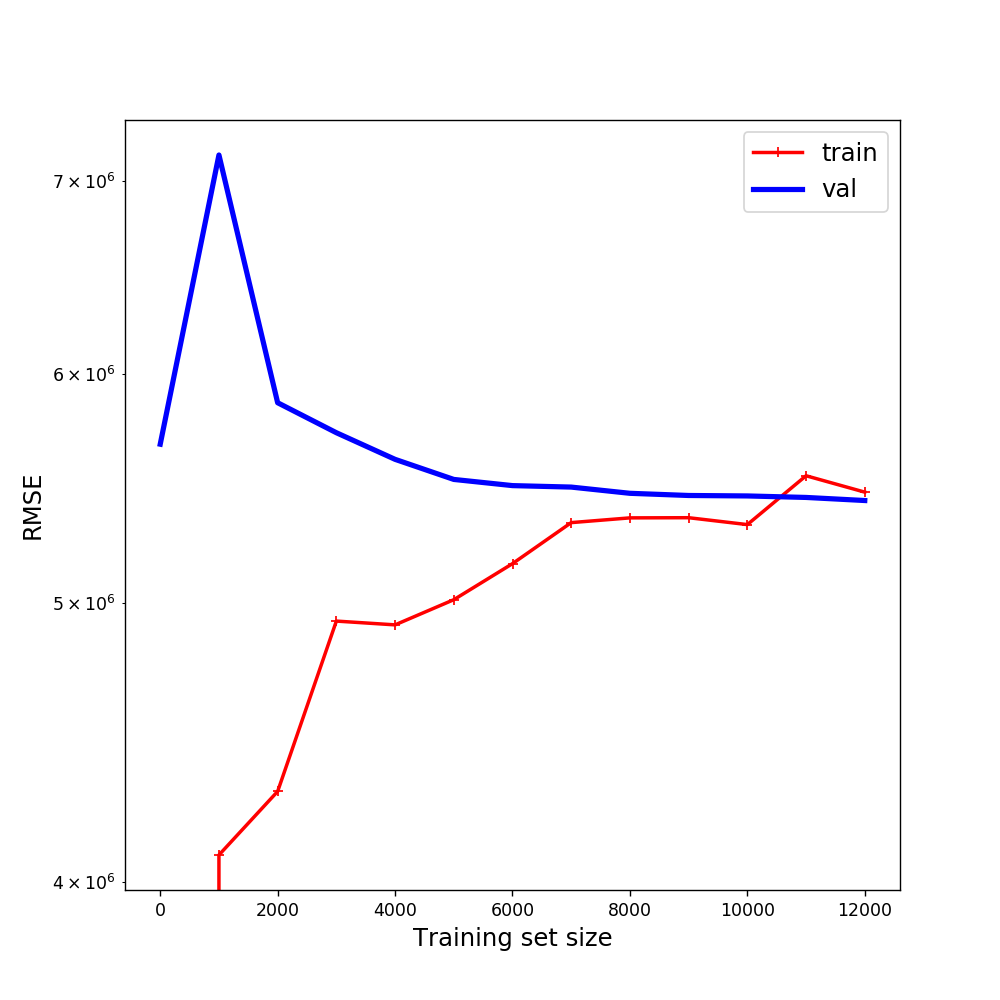

In [37]:
# Plots the learning curves for the Polynomial Regression Model
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
plot_learning_curves(poly_reg, np.append(X_train_poly, X_test_poly, axis=0), y, step=1000)
plt.show()

## Export the results <a id="export"></a>

In [38]:
predictions_series = pd.Series(data=predictions.flatten().tolist(), name="Prediction Linear Regression")
predictions_poly_series = pd.Series(data=predictions_poly.flatten().tolist(), name="Prediction Polynomial Regression")
predictions_lasso_series = pd.Series(data=predictions_lasso.flatten().tolist(), name="Prediction Lasso Regression")
X_test_df = pd.DataFrame(data=X_test, columns=features)
results_df = pd.concat([X_test_df, y_test.reset_index(), predictions_series, predictions_poly_series, 
                        predictions_lasso_series], axis=1, ignore_index=False)

display(results_df.head())

results_df.to_csv("data/output/predictions.csv", sep=";", index=False, float_format="%.0f")

,Overall,Potential,Wage,Special,Curve,Free kick accuracy,Long shots,Penalties,Reactions,CAM,CDM,CF,CM,LAM,LB,LCM,LDM,LF,LM,LS,LW,LWB,RAM,RB,RCM,RDM,RF,RM,RS,RW,RWB,ST,Preferred Position_CAM,Preferred Position_CB,Preferred Position_CDM,Preferred Position_LB,Preferred Position_LM,Preferred Position_LW,Preferred Position_RW,Preferred Position_ST,index,Value,Prediction Linear Regression,Prediction Polynomial Regression,Prediction Lasso Regression
0,0.625000,0.625000,0.024779,0.769034,0.720930,0.764045,0.764045,0.735632,0.647059,0.738462,0.542373,0.738462,0.701754,0.738462,0.500000,0.701754,0.542373,0.738462,0.741935,0.704918,0.753846,0.547170,0.738462,0.500000,0.701754,0.542373,0.738462,0.741935,0.704918,0.753846,0.547170,0.704918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1486,8500000.0,4.753322e+06,6.732793e+06,6.691195e+06
1,0.291667,0.458333,0.003540,0.516955,0.546512,0.303371,0.438202,0.310345,0.264706,0.400000,0.491525,0.400000,0.385965,0.400000,0.537037,0.385965,0.491525,0.400000,0.467742,0.327869,0.461538,0.528302,0.400000,0.537037,0.385965,0.491525,0.400000,0.467742,0.327869,0.461538,0.528302,0.327869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14611,260000.0,-7.146919e+05,-2.389956e+05,-3.768178e+05
2,0.479167,0.708333,0.028319,0.614203,0.767442,0.764045,0.707865,0.632184,0.500000,0.630769,0.355932,0.615385,0.561404,0.630769,0.296296,0.561404,0.355932,0.615385,0.629032,0.491803,0.646154,0.358491,0.630769,0.296296,0.561404,0.355932,0.615385,0.629032,0.491803,0.646154,0.358491,0.491803,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5858,1800000.0,5.220287e+06,3.180718e+06,3.033758e+06
3,0.375000,0.479167,0.007080,0.661548,0.453488,0.415730,0.662921,0.436782,0.485294,0.538462,0.644068,0.538462,0.578947,0.538462,0.611111,0.578947,0.644068,0.538462,0.564516,0.475410,0.538462,0.622642,0.538462,0.611111,0.578947,0.644068,0.538462,0.564516,0.475410,0.538462,0.622642,0.475410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11677,600000.0,5.308579e+05,2.190372e+05,2.743774e+05
4,0.333333,0.395833,0.001770,0.637876,0.616279,0.662921,0.573034,0.459770,0.500000,0.523077,0.559322,0.523077,0.543860,0.523077,0.555556,0.543860,0.559322,0.523077,0.548387,0.491803,0.538462,0.566038,0.523077,0.555556,0.543860,0.559322,0.523077,0.548387,0.491803,0.538462,0.566038,0.491803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13011,375000.0,-7.143724e+05,1.003008e+05,6.546131e+05
